# **Predict Calorie Expenditure**

## **Overview**

Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

## **Problem definition**

### **Goal**

Your goal is to predict **how many calories were burned** during a workout.

### **Evaluation**

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

### **Submission File**

For each id row in the test set, you must predict the continuous target, Calories. The file should contain a header and have the following format:
```
id,Calories
750000,93.2
750001,27.42
750002,103.8
etc.
```

### **Timeline**

- Start Date - May 1, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - May 31, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## **About the Tabular Playground Series**

The goal of the Tabular Playground Series is to provide the Kaggle community with a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The duration of each competition will generally only last a few weeks, and may have longer or shorter durations depending on the challenge. The challenges will generally use fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc.

### **Synthetically-Generated Datasets**

Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

### **Prizes**

- 1st Place - Choice of Kaggle merchandise
- 2nd Place - Choice of Kaggle merchandise
- 3rd Place - Choice of Kaggle merchandise

**Please note**: In order to encourage more participation from beginners, Kaggle merchandise will only be awarded once per person in this series. If a person has previously won, we'll skip to the next team.

### **Citation**

Walter Reade and Elizabeth Park. Predict Calorie Expenditure. https://kaggle.com/competitions/playground-series-s5e5, 2025. Kaggle.

## **Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Calories Burnt Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**

- train.csv - the training dataset; Calories is the continuous target
- test.csv - the test dataset; your objective is to predict the Calories for each row
- sample_submission.csv - a sample submission file in the correct format.

## **Metadata**

#### **Licence**

[MIT](https://www.mit.edu/~amini/LICENSE.md)

# **Problem Solution**

## **Importing necessary libraries**

In [32]:
# Installing the xgboost library using the 'pip' command.
%pip install xgboost
%pip install pandas
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Numpy and pandas
import numpy as np
import pandas as pd

# Fro plotting
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# To split the dataset into train/test and for tuning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold

# Algorithms to use
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Importing the XGBClassifier from the xgboost library
from xgboost import XGBRegressor
from sklearn.base import clone

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score, roc_auc_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_log_error

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the dataset**

In [4]:
# Define paths.
path_input ='./data'
path_output = './working'

In [5]:
# Define columns.
columns = ('id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories')
# Upper case constants for column-variables.
for (v, w) in zip(map(str.upper, columns), columns):
    exec("%s = '%s'" % (v, w))
# Read in the data.
train = pd.read_csv(# the train data
    '/'.join([path_input, 'train.csv']),               # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
test = pd.read_csv(# the test data to submit predictions of CALORIES.
    '/'.join([path_input, 'test.csv']),                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns[:-1],                              # Column labels defined (but no Calories-column).
    index_col = ID,                                    # ID column used for index.
    usecols = columns[:-1],                            # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)

## **Exploratory Data Analysis (EDA)**

### **Look for missing values**

In [6]:
# Number of rows and columns.
train.shape, test.shape

((750000, 8), (250000, 7))

In [7]:
# Are there duplicated rows?
train.duplicated().sum(),train.duplicated().sum()/train.shape[0]*100, test.duplicated().sum(),test.duplicated().sum()/test.shape[0]*100

(np.int64(2841),
 np.float64(0.3788),
 np.int64(918),
 np.float64(0.36719999999999997))

In [8]:
# Percentage of nan/missing values.
(train.isna().sum(axis=1)>0).sum()/train.shape[0]*100, (test.isna().sum(axis=1)>0).sum()/test.shape[0]*100

(np.float64(0.0), np.float64(0.0))

**Observations**
- No missing data detected.
- Train data has 750 thousand rows.
- Test data has 250 thousand rows.
- Around 0.4% of the rows are duplicates in the train/test data.

In [19]:
# Look at the first and last rows of the train data.
display(train.head()),display(train.tail());

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
id                                                                        
0     male   36 189.000  82.000    26.000     101.000     41.000   150.000
1   female   64 163.000  60.000     8.000      85.000     39.700    34.000
2   female   51 161.000  64.000     7.000      84.000     39.800    29.000
3     male   20 192.000  90.000    25.000     105.000     40.700   140.000
4   female   38 166.000  61.000    25.000     102.000     40.600   146.000

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
id                                                                            
749995    male   28 193.000  97.000    30.000     114.000     40.900   230.000
749996  female   64 165.000  63.000    18.000      92.000     40.500    96.000
749997    male   60 162.000  67.000    29.000     113.000     40.900   221.000
749998    male   45 182.000  91.000    17.000     102.000     40.300   109.000
749999  female   39 171.000  65.000    19.000      97.000     40.600   103.000

In [20]:
# Look at the first and last rows of the test data.
display(test.head()),display(test.tail());

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
id                                                                  
750000    male   45 177.000  81.000     7.000      87.000     39.800
750001    male   26 200.000  97.000    20.000     101.000     40.500
750002  female   29 188.000  85.000    16.000     102.000     40.400
750003  female   39 172.000  73.000    20.000     107.000     40.600
750004  female   30 173.000  67.000    16.000      94.000     40.500

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
id                                                                  
999995  female   56 159.000  62.000     6.000      85.000     39.400
999996    male   32 202.000 101.000     3.000      84.000     38.400
999997  female   31 164.000  64.000    14.000      98.000     40.100
999998  female   62 158.000  61.000    25.000     106.000     40.700
999999    male   31 199.000  96.000    15.000      98.000     39.900

In [10]:
# Information for each data-columns.
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         250000 non-null  object 
 1   Age         250000 non-null  int64  
 2   Height      250000 non-null  float64
 3   Weight      250000 non-null  float64
 4   Duration    250000 non-null  float64
 5   Hea

(None, None)

In [11]:
display(train.describe(include='all').T), display(test.describe(include='all').T);

count unique     top    freq    mean    std     min     25%  \
Sex            750000      2  female  375721     NaN    NaN     NaN     NaN   
Age        750000.000    NaN     NaN     NaN  41.420 15.175  20.000  28.000   
Height     750000.000    NaN     NaN     NaN 174.698 12.824 126.000 164.000   
Weight     750000.000    NaN     NaN     NaN  75.146 13.983  36.000  63.000   
Duration   750000.000    NaN     NaN     NaN  15.421  8.354   1.000   8.000   
Heart_Rate 750000.000    NaN     NaN     NaN  95.484  9.450  67.000  88.000   
Body_Temp  750000.000    NaN     NaN     NaN  40.036  0.780  37.100  39.600   
Calories   750000.000    NaN     NaN     NaN  88.283 62.395   1.000  34.000   

               50%     75%     max  
Sex            NaN     NaN     NaN  
Age         40.000  52.000  79.000  
Height     174.000 185.000 222.000  
Weight      74.000  87.000 132.000  
Duration    15.000  23.000  30.000  
Heart_Rate  95.000 103.000 128.000  
Body_Temp   40.300  40.700  41.500  
Calories    77.000 136.000 314.000

count unique     top    freq    mean    std     min     25%  \
Sex            250000      2  female  125281     NaN    NaN     NaN     NaN   
Age        250000.000    NaN     NaN     NaN  41.452 15.178  20.000  28.000   
Height     250000.000    NaN     NaN     NaN 174.726 12.822 127.000 164.000   
Weight     250000.000    NaN     NaN     NaN  75.148 13.980  39.000  63.000   
Duration   250000.000    NaN     NaN     NaN  15.415  8.349   1.000   8.000   
Heart_Rate 250000.000    NaN     NaN     NaN  95.479  9.450  67.000  88.000   
Body_Temp  250000.000    NaN     NaN     NaN  40.036  0.778  37.100  39.600   

               50%     75%     max  
Sex            NaN     NaN     NaN  
Age         40.000  52.000  79.000  
Height     174.000 185.000 219.000  
Weight      74.000  87.000 126.000  
Duration    15.000  23.000  30.000  
Heart_Rate  95.000 103.000 128.000  
Body_Temp   40.300  40.600  41.500

**Observations**
- The Sex-column is labelled with male/female and needs to be digitised later.
- Data values seem to be reasonable - and no strange values detected in the above tables.

### **Make Plots**

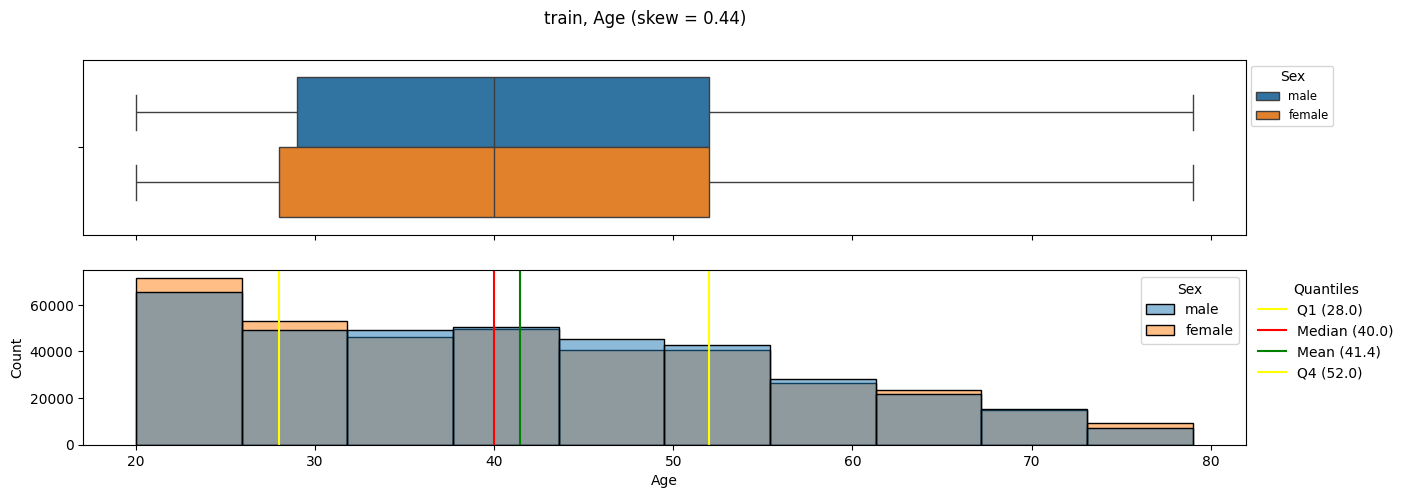

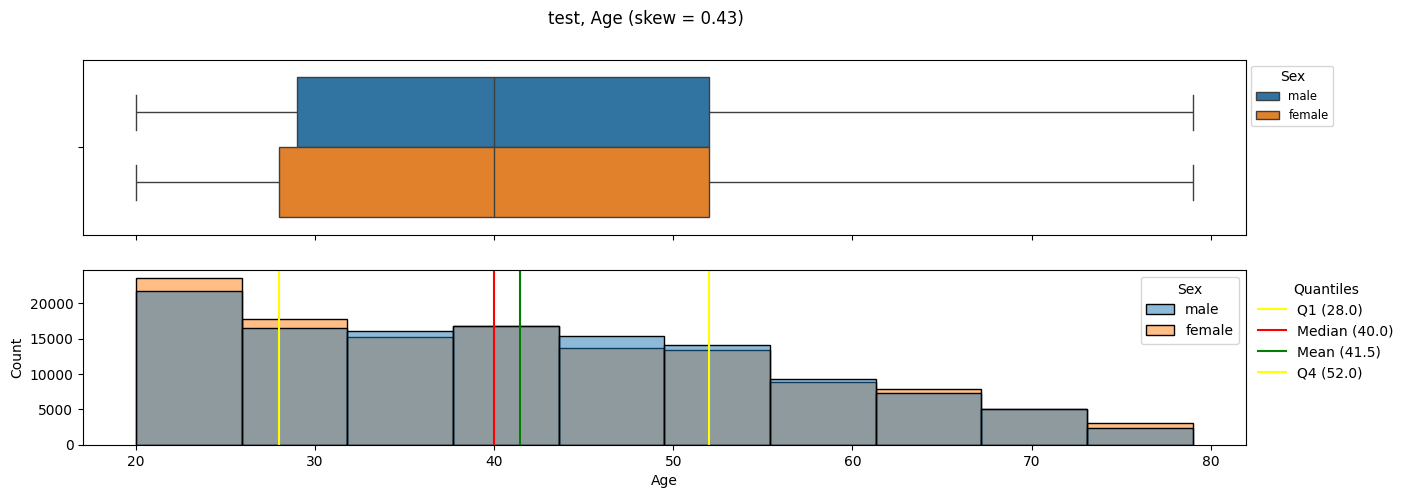

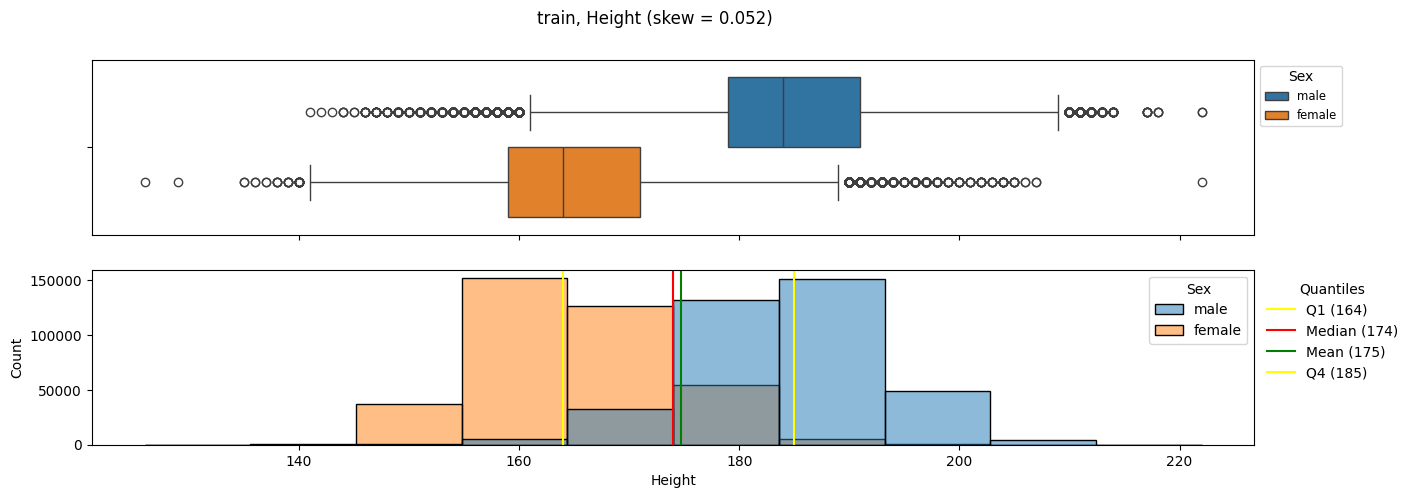

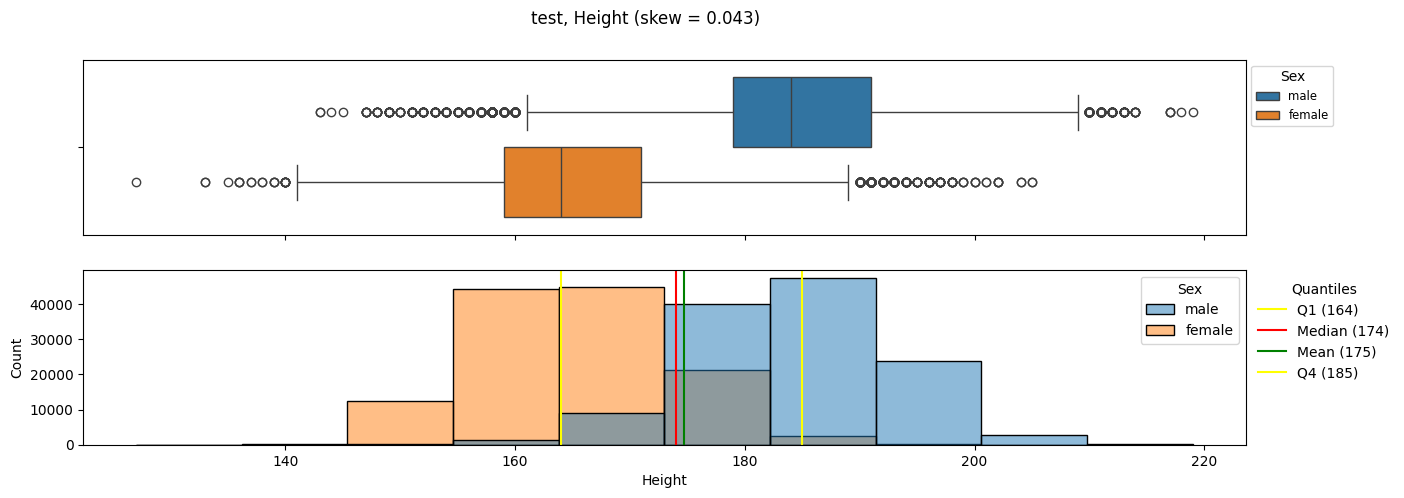

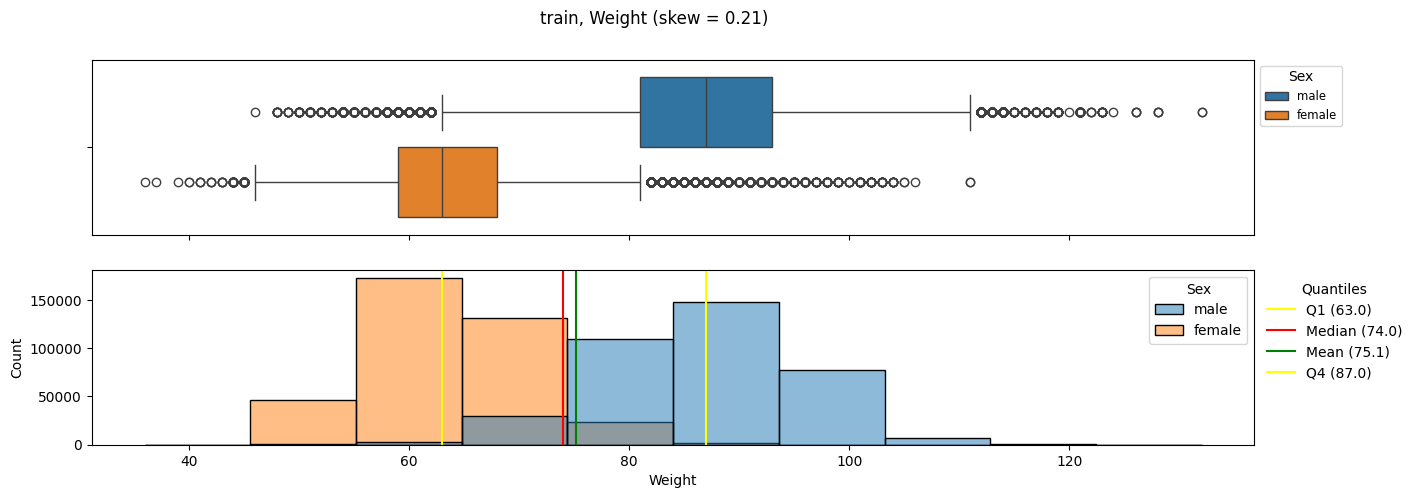

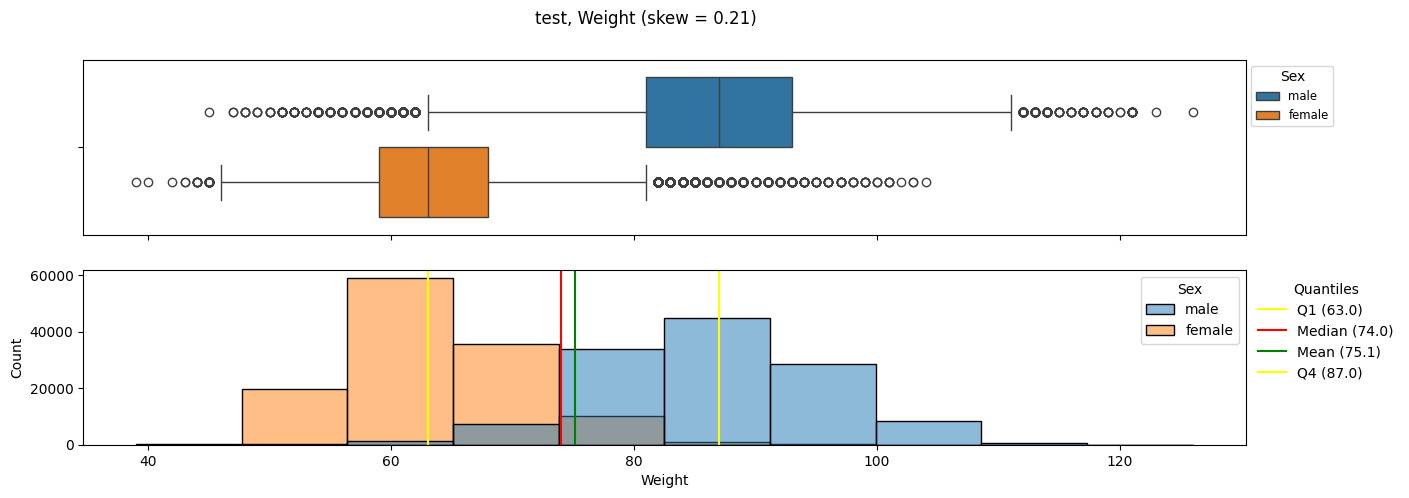

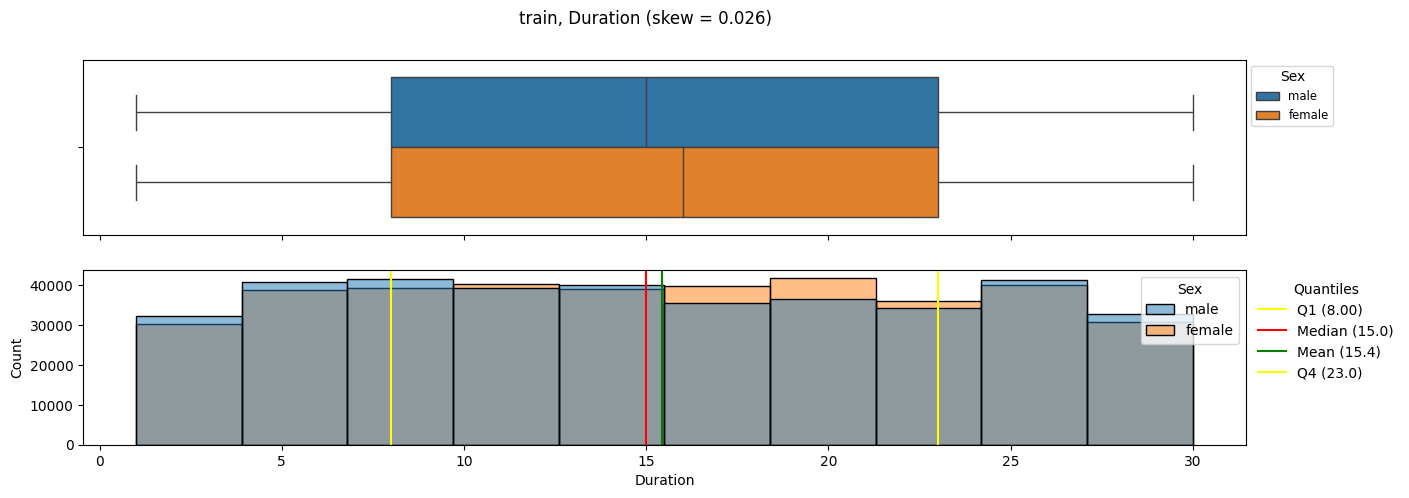

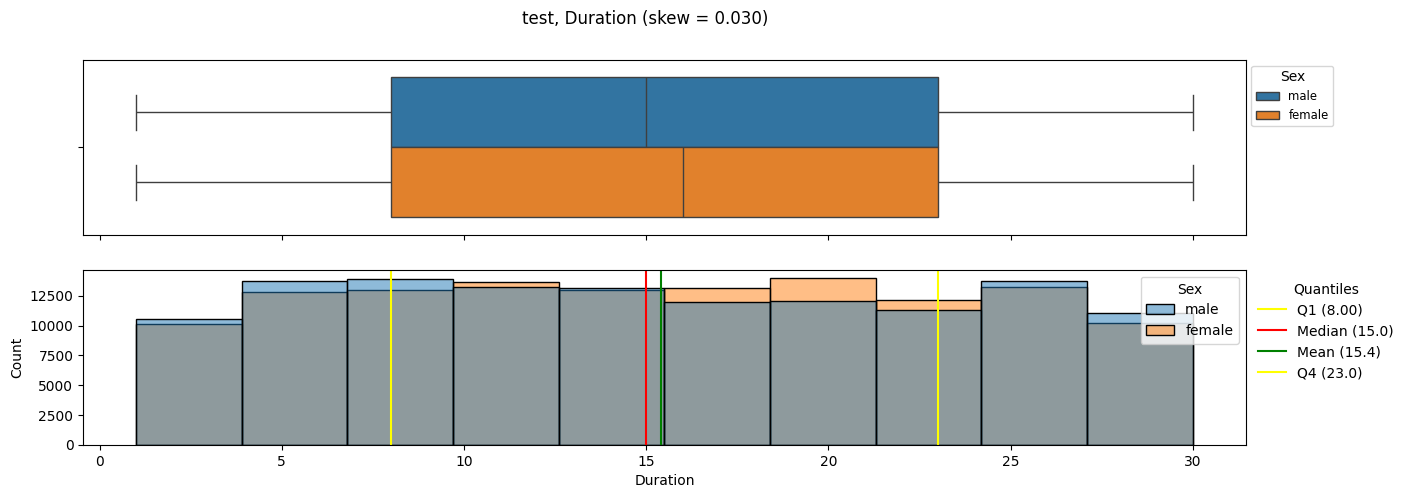

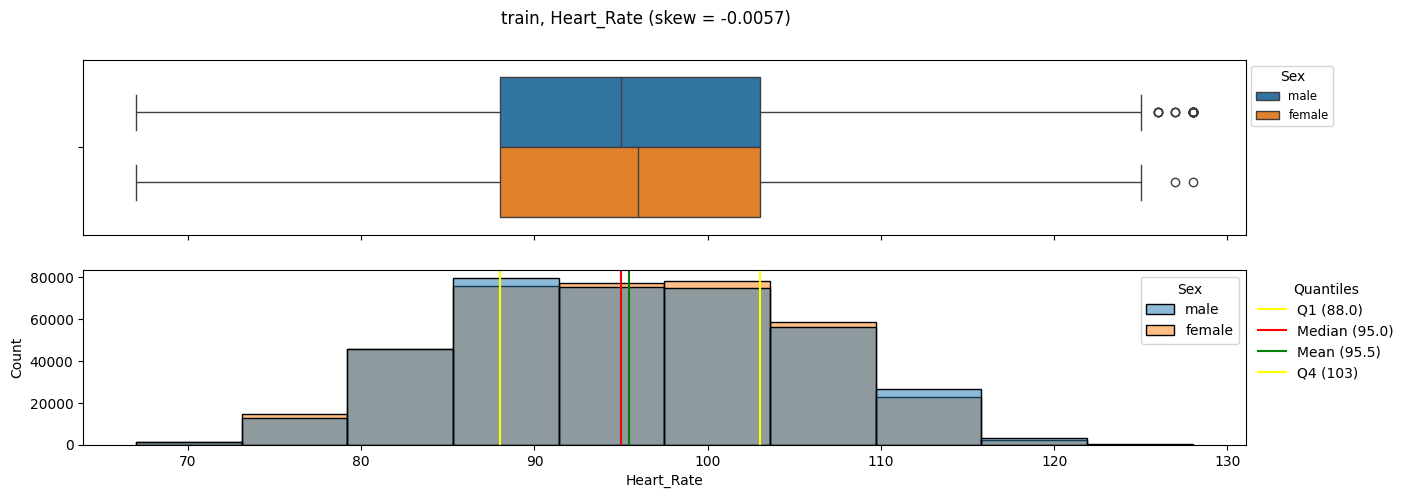

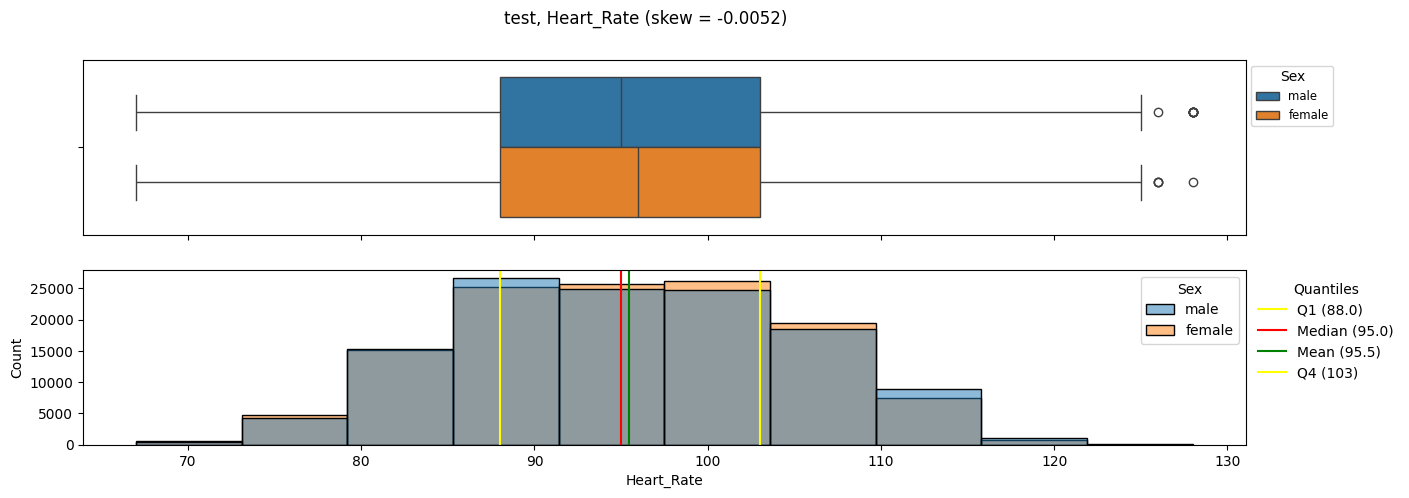

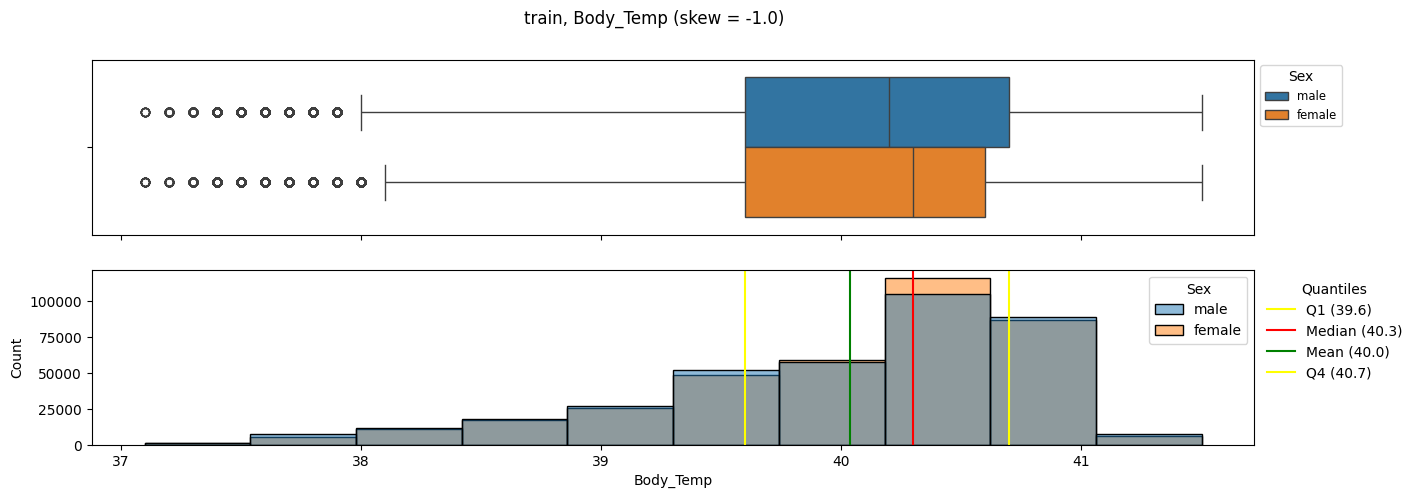

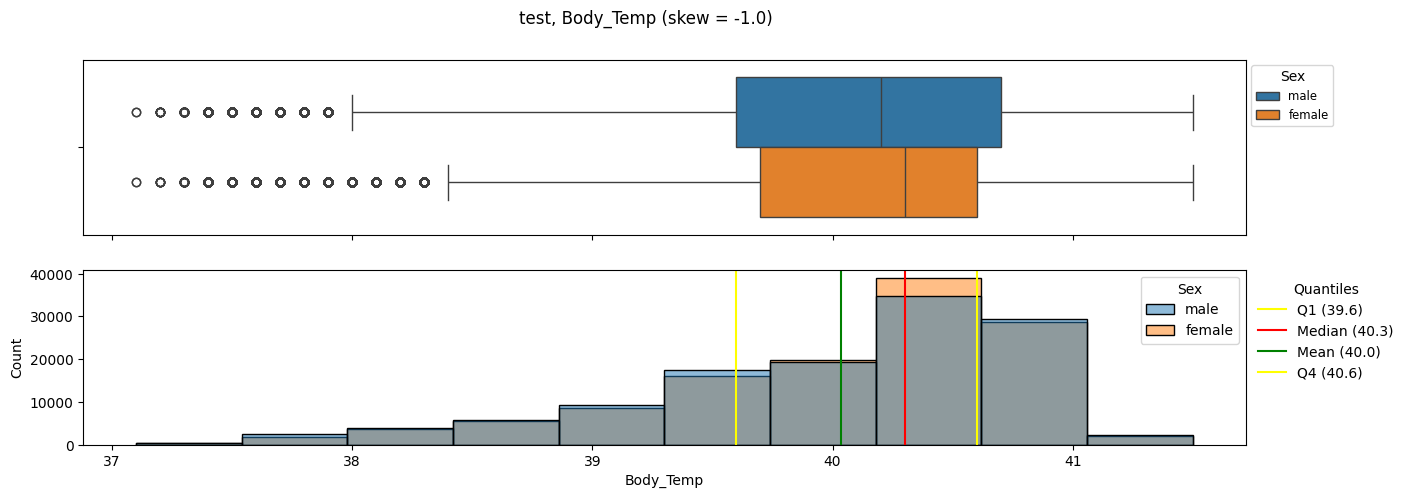

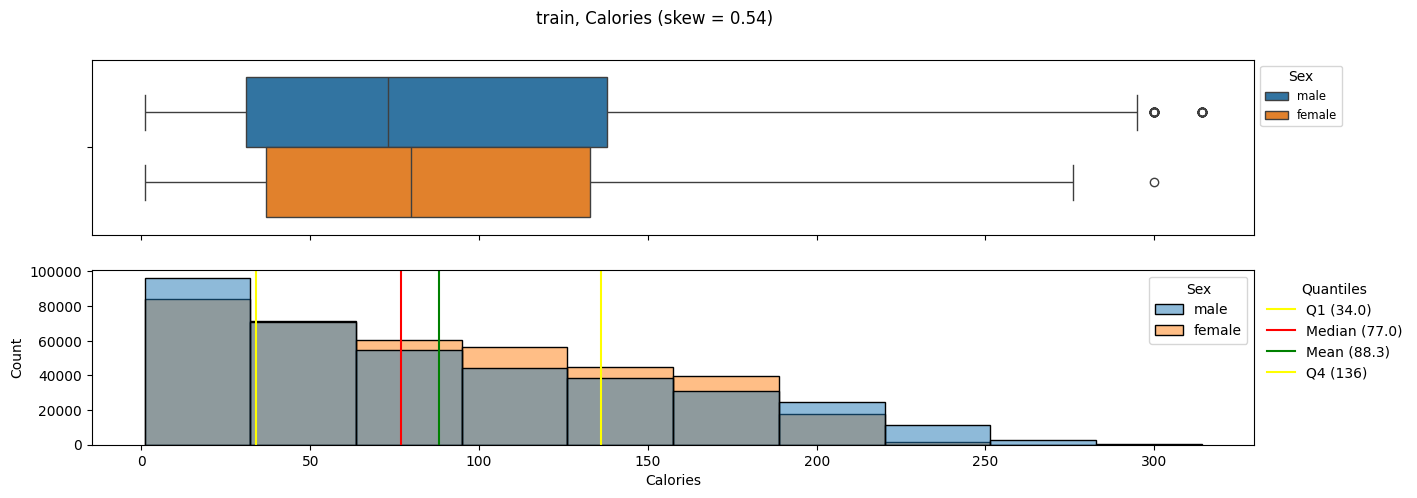

In [12]:
def plot_dist(data, x, w=15, h=5, nbins=10, hue=False, title=None, xlabel=None, ylabel=None):
    fig, (axsU, axsL) = plt.subplots(2, 1, figsize=(w,h), sharex=True)
    skew = f"(skew = {data[x].skew():#,.2g}".removesuffix(".") + ")"
    # Add title
    if (title):
        fig.suptitle(f"{title} {skew}")
    else:
        fig.suptitle(f"Distribution of {data[x].name} {skew}")
    sns.histplot(data=data, x=x, ax=axsL, kde=False, bins=nbins, hue=hue, legend=bool(hue))
    legL = axsL.get_legend() # capture the legend.
    sns.boxplot(data=data, x=x, ax=axsU, hue=hue, legend=bool(hue))
    if hue: axsU.legend(loc="upper left", bbox_to_anchor=(1,1), title="Sex", fontsize='small') 
    # Calculate mean and median and add them as labels.
    q25, median, q75, mean = (data[x].quantile(0.25), data[x].median(), data[x].quantile(0.75), data[x].mean())
    l1, l2, l3, l4 = (
        f"Q1 ({q25:#,.3g}".removesuffix(".") + ")", 
        f"Median ({median:#,.3g}".removesuffix(".") + ")",
        f"Mean ({mean:#,.3g}".removesuffix(".") + ")",
        f"Q4 ({q75:#,.3g}".removesuffix(".") + ")"
    )
    q1, q2, q3, q4 = (
        plt.axvline(q25, color='yellow', label=l1),
        plt.axvline(median, color='red', label=l2),
        plt.axvline(mean, color='green', label=l3),
        plt.axvline(q75, color='yellow', label=l4)
    )
    axsL.legend(handles=[q1, q2, q3, q4], loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium', frameon=False, title="Quantiles")
    if hue: axsL.add_artist(legL) # It is necessary to add this legend back.
    # Add labels on axes.
    if (xlabel): plt.xlabel(xlabel) 
    if (ylabel): plt.ylabel(ylabel)
    plt.show()
# Make some distributions plots - and distinguish between female/male.
for COL in columns[2:-1]:
    plot_dist(data=train, x=COL, hue=SEX, title=f"train, {COL}")
    plot_dist(data=test, x=COL, hue=SEX, title=f"test, {COL}")
plot_dist(data=train, x=CALORIES, hue=SEX, title=f"train, {CALORIES}") # Only train data has CALORIES column.

In [207]:
# Some more plots for looking at connection between variable on a scatter plot.
# First some definitions.
sns.set(rc={"figure.figsize": (10, 4)}) # Size of figure.
plegend = {'loc':'upper left', 'bbox_to_anchor':(1, 1), 'fontsize':'medium', 'title':"Sex"} # How to adjust legend.

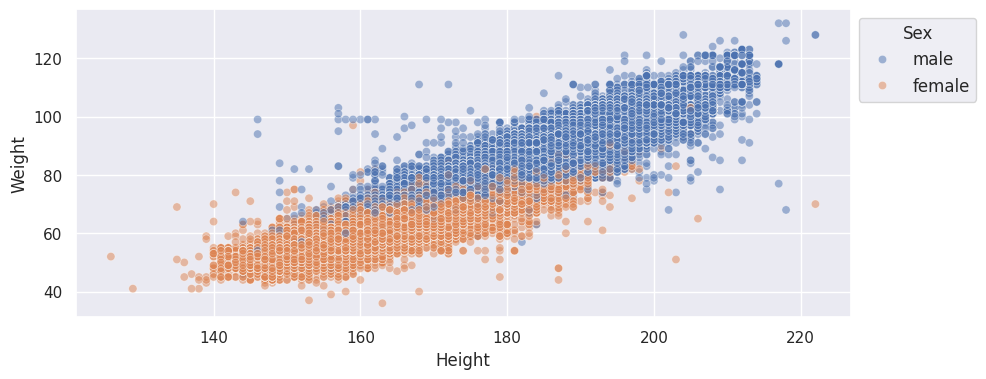

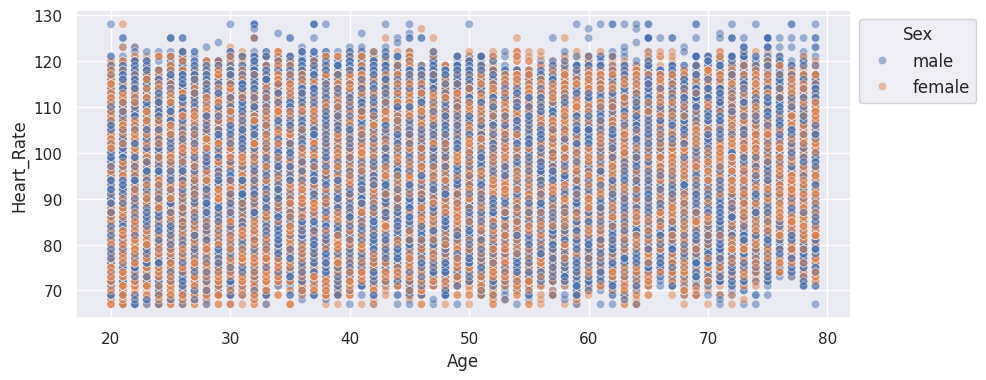

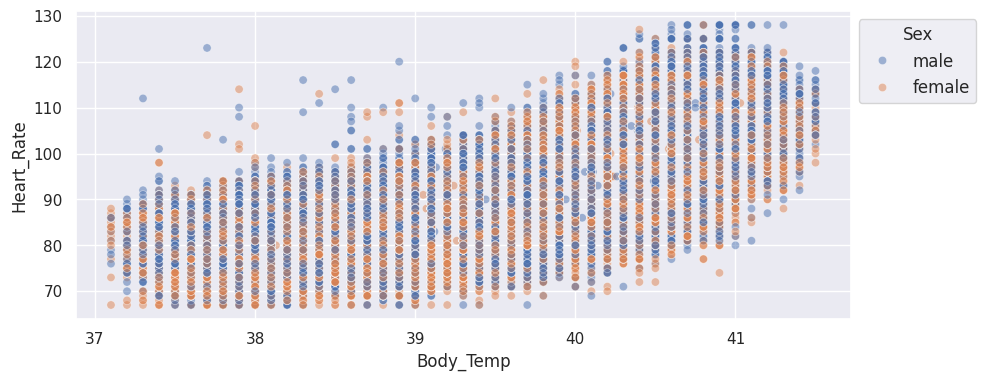

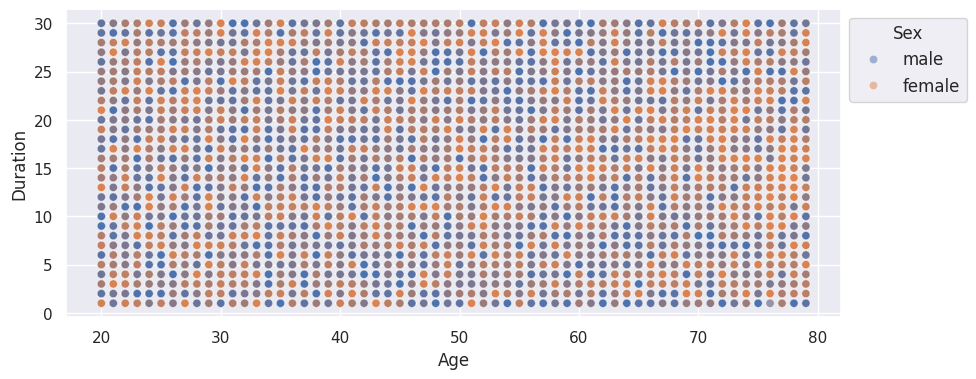

In [208]:
# Height vs Weight
sns.scatterplot(data=train, x=HEIGHT, y=WEIGHT, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Heart Rate vs Age
sns.scatterplot(data=train, x=AGE, y=HEART_RATE, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Heart Rate vs Body Temperature
sns.scatterplot(data=train, x=BODY_TEMP, y=HEART_RATE, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Duration vs Age
sns.scatterplot(data=train, x=AGE, y=DURATION, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();

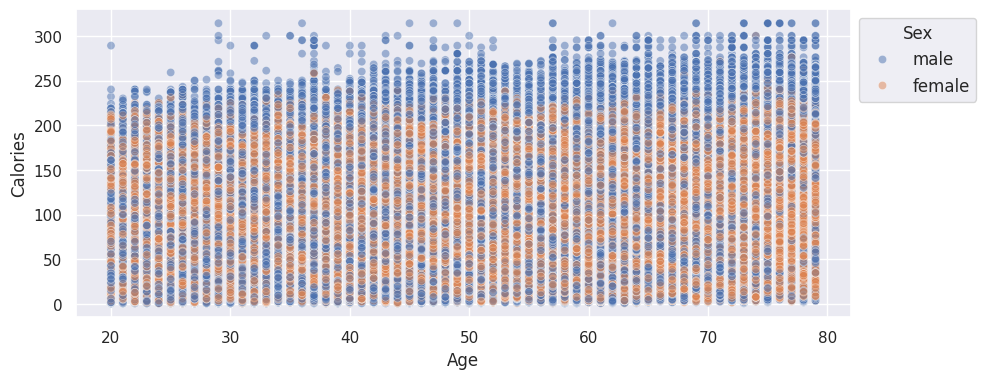

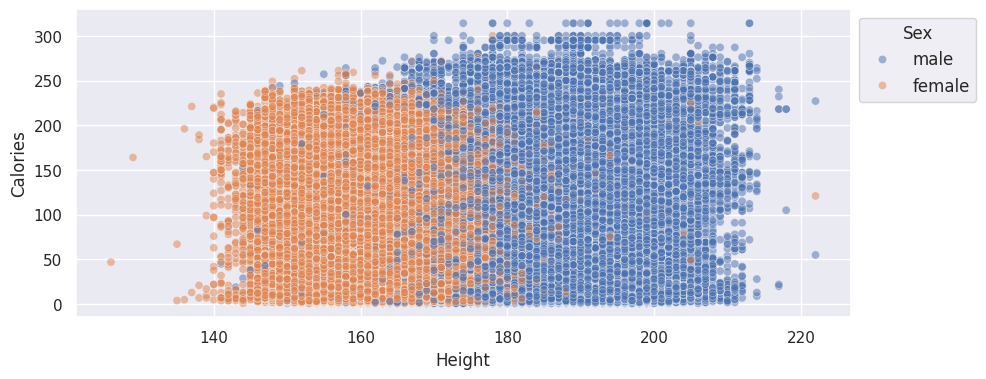

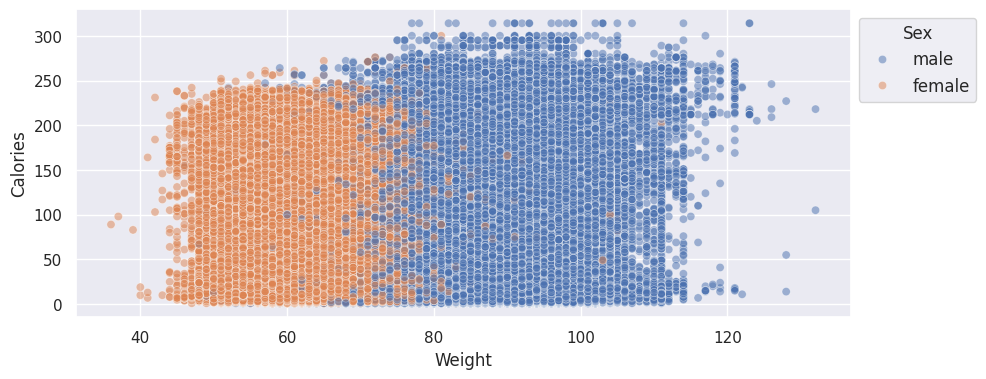

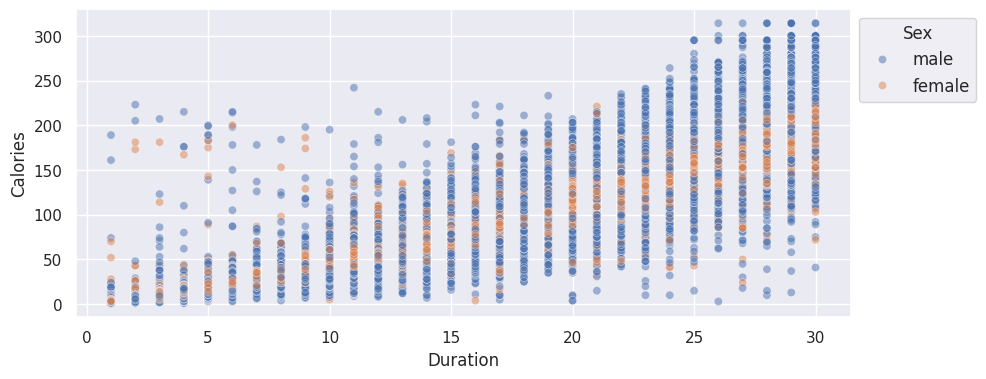

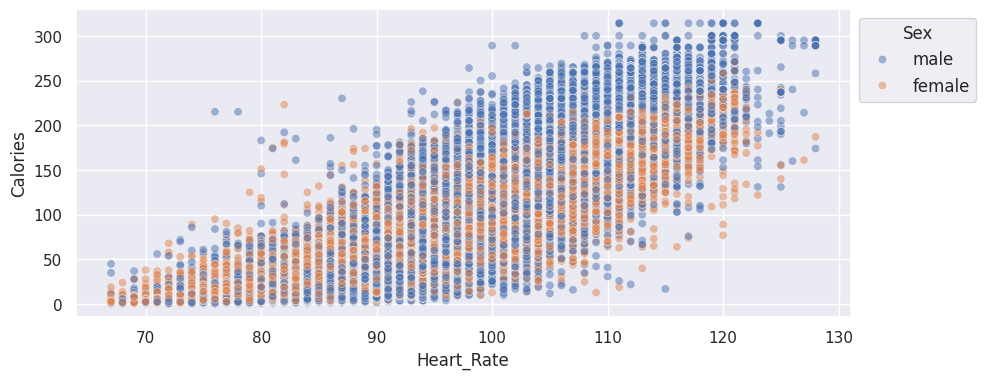

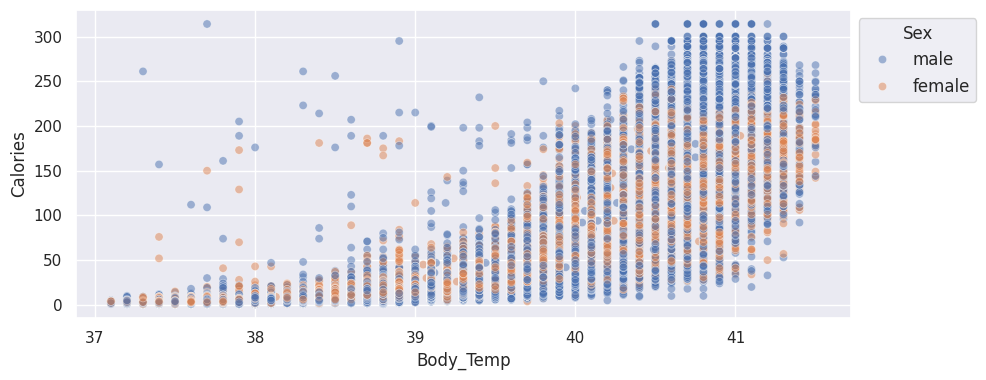

In [209]:
# Calories vs AGE
sns.scatterplot(data=train, x=AGE, y=CALORIES, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Calories vs HEIGHT
sns.scatterplot(data=train, x=HEIGHT, y=CALORIES, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Calories vs Weight
sns.scatterplot(data=train, x=WEIGHT, y=CALORIES, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Calories vs Duration
sns.scatterplot(data=train, x=DURATION, y=CALORIES, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Calories vs Heart Rate
sns.scatterplot(data=train, x=HEART_RATE, y=CALORIES, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();
# Calories vs Body Temperature
sns.scatterplot(data=train, x=BODY_TEMP, y=CALORIES, alpha=0.5, hue=SEX);plt.legend(**plegend);plt.show();

## **Modelling**

### **Digitising**

In [9]:
# Make a copy of data.
train_df = train.copy()
test_df = test.copy()

In [10]:
# Leta male be 0 and female be 1.
rplc={'male': 0, 'female': 1}
train_df.replace(rplc, inplace=True), test_df.replace(rplc, inplace=True)

(None, None)

In [10]:
display(train_df.head()),display(test_df.head());

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
id                                                                     
0     0   36 189.000  82.000    26.000     101.000     41.000   150.000
1     1   64 163.000  60.000     8.000      85.000     39.700    34.000
2     1   51 161.000  64.000     7.000      84.000     39.800    29.000
3     0   20 192.000  90.000    25.000     105.000     40.700   140.000
4     1   38 166.000  61.000    25.000     102.000     40.600   146.000

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
id                                                               
750000    0   45 177.000  81.000     7.000      87.000     39.800
750001    0   26 200.000  97.000    20.000     101.000     40.500
750002    1   29 188.000  85.000    16.000     102.000     40.400
750003    1   39 172.000  73.000    20.000     107.000     40.600
750004    1   30 173.000  67.000    16.000      94.000     40.500

In [11]:
# We do not need many identical rows (but we keep all rows of test, as that is used for scoring).
train_df.drop_duplicates(inplace=True)

### **Feature Engineering**

In [12]:
# Brainstorm!


### **Scaling data**

In [12]:
NUM_COLUMNS = list(columns[1:])
SCALED_COLUMNS = list(columns[1:-1])

sc = StandardScaler()

train_scaled = train_df.copy()
test_scaled = test_df.copy()

train_scaled[SCALED_COLUMNS] = sc.fit_transform(train_df[SCALED_COLUMNS])
test_scaled[SCALED_COLUMNS]  = sc.transform(test_df[SCALED_COLUMNS])

In [13]:
train_scaled.head(), test_scaled.head()

(      Sex    Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
 id                                                                         
 0  -1.002 -0.357   1.116   0.491     1.265       0.582      1.235   150.000
 1   0.998  1.487  -0.912  -1.083    -0.890      -1.111     -0.433    34.000
 2   0.998  0.631  -1.068  -0.797    -1.010      -1.216     -0.305    29.000
 3  -1.002 -1.411   1.350   1.063     1.145       1.006      0.850   140.000
 4   0.998 -0.225  -0.678  -1.012     1.145       0.688      0.722   146.000,
           Sex    Age  Height  Weight  Duration  Heart_Rate  Body_Temp
 id                                                                   
 750000 -1.002  0.236   0.180   0.419    -1.010      -0.899     -0.305
 750001 -1.002 -1.016   1.974   1.564     0.547       0.582      0.594
 750002  0.998 -0.818   1.038   0.705     0.068       0.688      0.465
 750003  0.998 -0.159  -0.210  -0.153     0.547       1.217      0.722
 750004  0.998 -0.752  -0.132  -0.

### **Covariance Matrix**

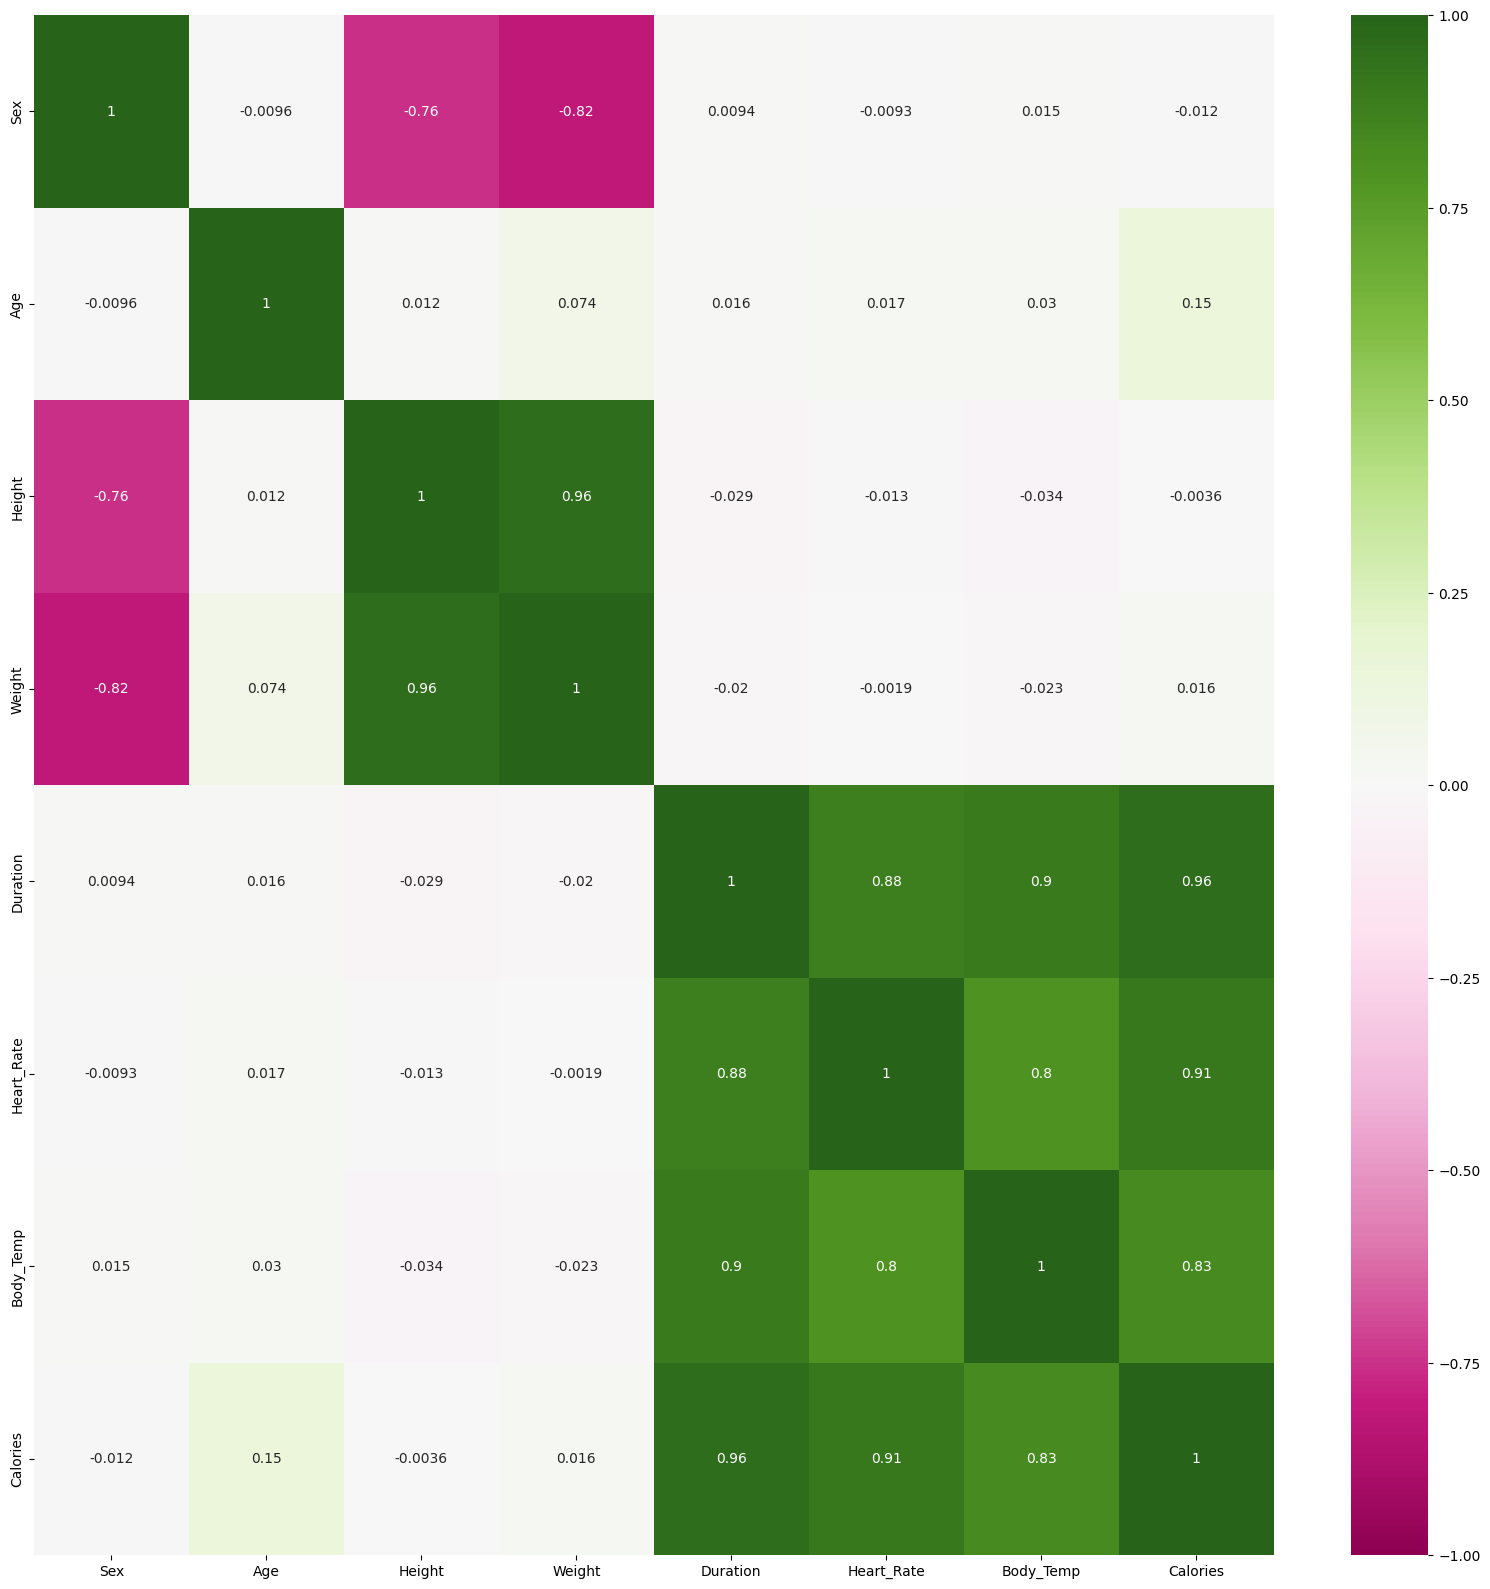

Calories      1.000
Duration      0.960
Heart_Rate    0.909
Body_Temp     0.829
Age           0.146
Weight        0.016
Sex          -0.012
Height       -0.004
Name: Calories, dtype: float64

In [15]:
plt.figure(figsize  = (20, 20))
corr = train_scaled[NUM_COLUMNS].corr()
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, cmap = "PiYG")
plt.show()

corr[CALORIES].sort_values(key=lambda col: -abs(col))

### **Split data for modelling and validation sets**

In [14]:
# Dividing train data into X (input data matrix) and y (output vector)
X = train_scaled.drop([CALORIES], axis=1)
y = train_scaled[CALORIES]

In [15]:
# Splitting data into training and validation set:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

display(X_train.shape, X_val.shape)

(523011, 7)

(224148, 7)

### **Metric Functions**

In [17]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    rmsle = np.sqrt(mean_squared_log_error (target, pred)) # to compute RMSLE
    mae = mean_absolute_error(target, pred)  # to compute MAE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSLE": rmsle,
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
        },
        index=[0],
    )

    return df_perf

### **Models**

In [43]:
dtree = DecisionTreeClassifier(random_state=1)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [44]:
dtree_model_train_perf = model_performance_regression(dtree, X_train, y_train)
dtree_model_train_perf

RMSLE  RMSE   MAE  R-squared  Adj. R-squared
0  0.005 0.269 0.013      1.000           1.000

In [ ]:
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train[:500000], y_train[:500000])

In [ ]:
rf_estimator_model_train_perf = model_performance_regression(
    rf_estimator, X_train[:500000], y_train[:500000]
)
rf_estimator_model_train_perf

In [18]:
xgb_estimator = XGBRegressor(random_state=1)
xgb_estimator.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
xgb_estimator_model_train_perf = model_performance_regression(
    xgb_estimator, X_train, y_train
)
xgb_estimator_model_train_perf

RMSLE  RMSE   MAE  R-squared  Adj. R-squared
0  0.063 3.527 2.287      0.997           0.997

In [42]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [
        dtree_model_train_perf.T,
        rf_estimator_model_train_perf.T,
        xgb_estimator_model_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Random Forest",
    "Xgboost",
]
print("Training performance comparison:")
models_train_comp_df.T

NameError: name 'dtree_model_train_perf' is not defined

## **Tuning Models**

In [ ]:
# Tuning Xgboost!
# randint(low,high) => {low,high-1}
# uniform(loc,scale) => [loc, loc + scale]
# Setting up parameter grid to tune the hyperparameters.
param_distributions = {
    'learning_rate': uniform(0,1),                                     # Boosting learning rate (xgb’s “eta”).
    'n_estimators': randint(1,501),                                    # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'max_depth': randint(1,101),                                       # Maximum tree depth for base learners.
    'random_state': [1],                                               # For setting random state for prediction algorithm.
}
# Performing 3-fold cross-validation to tune the hyperparameters.
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=1),
    param_distributions=param_distributions,
    n_iter=100,
    #refit="r2",
    #scoring=["r2"],
    cv=3,
    n_jobs=-1,
    #pre_dispatch=8,

)

# Fitting the data.
xgb_search.fit(X_train, y_train)

# Best score (estimator’s score method is used if scoring and refit parameters are not set).
print(xgb_search.best_score_)

# Combination of parameters that gave the best score.
print(xgb_search.best_params_)

In [20]:
prediction = xgb_estimator.predict(test_scaled)

In [24]:
prediction.round(3)

array([ 27.102, 107.421,  85.773, ...,  72.173, 164.129,  75.951],
      shape=(250000,), dtype=float32)

In [37]:
submission = pd.read_csv(path_input + "/sample_submission.csv")
submission = pd.DataFrame({
    "id": submission["id"],
    "Calories": prediction.round(3)
})

In [38]:
submission

id  Calories
0       750000    27.102
1       750001   107.421
2       750002    85.773
3       750003   126.688
4       750004    76.118
...        ...       ...
249995  999995    27.230
249996  999996     9.155
249997  999997    72.173
249998  999998   164.129
249999  999999    75.951

[250000 rows x 2 columns]

In [45]:
submission.loc[submission["Calories"] <= 0, "Calories"] = 0

In [46]:
submission[submission["Calories"] <= 0]

id  Calories
239850  989850     0.000

In [47]:
submission.to_csv(path_output + '/submission.csv', index = False)